In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import gdt.missions.fermi 
import gdt.core 
from gdt.missions.fermi.gbm.finders import TriggerFtp
from gdt.missions.fermi.gbm.localization import GbmHealPix
from gdt.core import data_path
from gdt.core.plot.sky import EquatorialPlot
import os
from ligo.skymap.io import read_sky_map
import ligo.skymap.plot
from astropy.table import Table
from astropy.io import fits
import astropy_healpix as ah
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
import random

# read in existing maps to see what they look like

In [3]:
# add: read in a handful of events to get a variety of shapes and sizes?

# initialize the trigger data finder to pull from event 190915240
healpix_finder = TriggerFtp('190915240')

# download and open healpix localization data for the event
healpix_finder.get_healpix(download_dir=data_path.joinpath('190915240'))
filepath = data_path.joinpath('190915240/glg_healpix_all_bn190915240_v00.fit')
loc = GbmHealPix.open(filepath)
print(loc)

/home/kira/mypy/environments/astroenv/lib/python3.12/site-packages/gdt/core/heasarc.py:253: UserWarning: FTP access to heasarc.gsfc.nasa.gov is unreliable due to high server loads. Users should switch to HTTPS access.
  warnings.warn(


Output()

<GbmHealPix: glg_healpix_all_bn190915240_v00.fit
 NSIDE=128; trigtime=590219102.911008;
 centroid=(48.8671875, 4.181528273111476)>


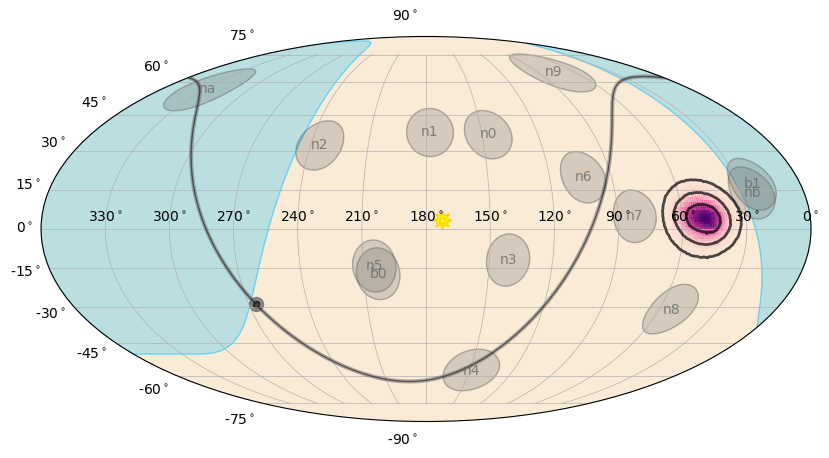

In [3]:
%matplotlib inline

# initialize
skyplot = EquatorialPlot()

# add our healpix localization
skyplot.add_localization(loc)
plt.show()

# simulate skymaps

In [3]:
def simulate_gauss_localization(ra, dec, radius):
    gauss_map = GbmHealPix.from_gaussian(ra, dec, radius)
    return gauss_map

def equatorial_plot(map):
    skyplot = EquatorialPlot()
    skyplot.add_localization(map, detectors=[])
    plt.show()

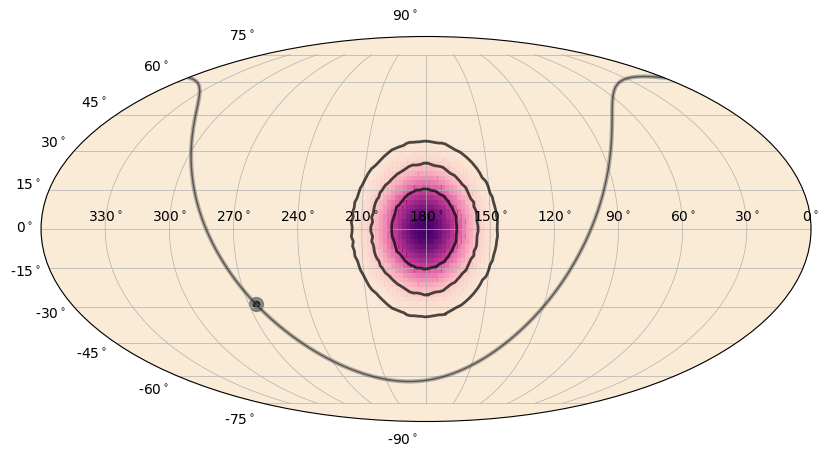

In [18]:
gauss_map = simulate_gauss_localization(180, 0, 10)
equatorial_plot(gauss_map) 

In [4]:
# load some GW skymaps from local directory

def load_skymap_fits(filename, directory):
    filepath = os.path.join(directory, filename)
    with fits.open(filepath) as hdul:
        table = Table.read(hdul)
        return table, hdul

# load gracedb skymaps
directory = 'skymaps/gracedb/'
skymap_load = [load_skymap_fits(file, directory) for file in os.listdir(directory) if file.endswith('.fits')]
skymap_gracedb = [x[0] for x in skymap_load]
hdul_gracedb = [x[1] for x in skymap_load]  
names_gracedb = [os.path.splitext(file)[0] for file in os.listdir(directory) if file.endswith('.fits')]

In [5]:
example_skymap = skymap_gracedb[0]  

In [6]:
def get_kn_coords(skymap, contour=0.9):
    """
    Given a LIGO skymap, select pixel and get coords to assign as the KN location 
    with a pixel's liklihood of selection reflecting it's probability contained
    """
    #skymap.sort('PROBDENSITY', reverse = True)
    level, ipix = ah.uniq_to_level_ipix(skymap['UNIQ']) # ipix = sky location
    nside = ah.level_to_nside(level) # nside = multi-order pixel resolution
    pixel_area = ah.nside_to_pixel_area(ah.level_to_nside(level)) # pixel area in steradians
    prob = pixel_area * skymap['PROBDENSITY']
    #cumprob = np.cumsum(prob)
    # i = cumprob.searchsorted(contour)
    # a90_probs = prob[:i]
    # index = np.arange(0,i)
    index = np.arange(0, len(prob))
    kn_pixel = random.choices(index, weights=prob, k=1)[0]
    print(f'index of KN pixel: {kn_pixel}, probability: {prob[kn_pixel]}')
    lon, lat = ah.healpix_to_lonlat(ipix[kn_pixel], nside[kn_pixel])
    coords = SkyCoord(lon, lat, unit='rad', frame='icrs')
    radec = (coords.ra.deg, coords.dec.deg)
    return radec

def get_GBM_from_GW(gw_skymap):
    %matplotlib agg
    kn_coords_gw = get_kn_coords(gw_skymap)
    #make GRB skymap template
    radius = np.random.uniform(5, 10)
    gauss_map = GbmHealPix.from_gaussian(100, 0, radius)
    # select kn location in grb skymap taking into account pixel probability
    approx_res = np.sqrt(gauss_map.pixel_area)
    numpts_ra = int(np.floor(0.5*360.0/approx_res))
    numpts_dec= int(np.floor(0.5*180.0/approx_res))
    #probs has dimentions of 98 x 196, ra had 196 elements, dec has 98 elements
    probs, ra, dec = gauss_map.prob_array(numpts_ra = numpts_ra, numpts_dec = numpts_dec)
    flattened_ra = np.tile(ra, len(dec))
    flattened_dec = np.repeat(dec, len(ra))
    coords = zip(flattened_ra, flattened_dec)
    flattened_probs = np.concatenate(probs).ravel()
    select_index = np.arange(0, len(flattened_probs))
    select_pixel_grb = random.choices(select_index, weights=flattened_probs, k=1)[0]
    #translate the GRB skymap so selected pixel lines up with GW kn location
    # given the symmetric gaussian, we can just shift the center of the map
    ra_shift = kn_coords_gw[0] - flattened_ra[select_pixel_grb]
    dec_shift = kn_coords_gw[1] - flattened_dec[select_pixel_grb]
    skymap_grb = GbmHealPix.from_gaussian(ra_shift + 100, dec_shift + 0, radius)
    print(f'coords of KN: {kn_coords_gw}')
    return skymap_grb, kn_coords_gw

In [12]:
skymap_grb, kn_coords= get_GBM_from_GW(example_skymap)

index of KN pixel: 12690, probability: 0.0001661010200227942
coords of KN: (266.484375, 7.632146323658412)


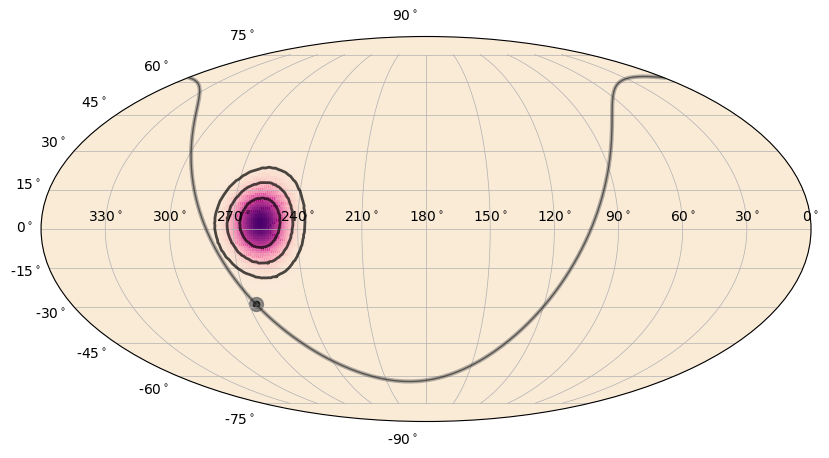

In [13]:
#grb
%matplotlib inline

equatorial_plot(skymap_grb) 

In [22]:
def extract_skymap_data(skymap):
    ring50 = skymap.confidence_region_path(0.5)
    ring90 = skymap.confidence_region_path(0.9)

    approx_res = np.sqrt(skymap.pixel_area)
    numpts_ra = int(np.floor(0.5*360.0/approx_res))
    numpts_dec= int(np.floor(0.5*180.0/approx_res))
    probs, ra, dec = skymap.prob_array(numpts_ra = numpts_ra, numpts_dec = numpts_dec)
    flattened_ra = np.tile(ra, len(dec))
    flattened_dec = np.repeat(dec, len(ra))
    flattened_probs = np.concatenate(probs).ravel()
    return ring50, ring90, flattened_ra, flattened_dec, flattened_probs

In [23]:
def plot_gw_grb(skymap, url, kn_coords):
    ring50, ring90, flattened_ra, flattened_dec, flattened_probs = extract_skymap_data(skymap)
    
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': 'astro degrees mollweide'})
    ax.grid()

    # plot GW skymap
    img = ax.imshow_hpx(url, cmap='cylon')
    # img = ax.imshow_hpx('skymaps/gracedb/S230518h.fits', cmap='cylon')
    
    #plot GRB skymap
    ra50 = [x[0] for x in ring50[0]]
    dec50 = [x[1] for x in ring50[0]]
    ax.plot(ra50, dec50, transform=ax.get_transform('icrs'), c="black")
    ra90 = [x[0] for x in ring90[0]]
    dec90 = [x[1] for x in ring90[0]]
    ax.plot(ra90, dec90, transform=ax.get_transform('icrs'), c="black")

    filtered_indices = np.where(flattened_probs > 0.0001)
    filtered_ra = flattened_ra[filtered_indices]
    filtered_dec = flattened_dec[filtered_indices]
    filtered_probs = flattened_probs[filtered_indices]
    ax.scatter(filtered_ra, filtered_dec, transform=ax.get_transform('icrs'), c=filtered_probs, cmap='plasma', alpha=0.1)

    # Plot the kn_coords
    ax.scatter(kn_coords[0], kn_coords[1], transform=ax.get_transform('icrs'), color='blue', marker='*', s=200)

    plt.show()

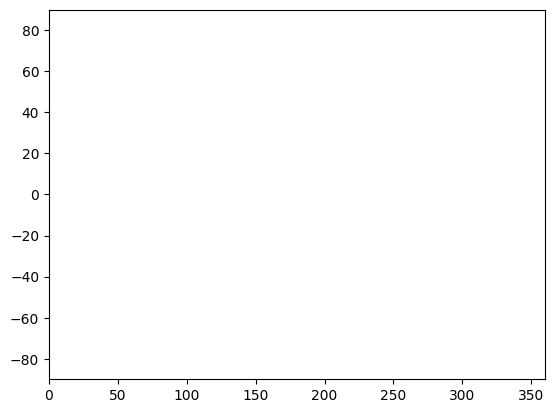

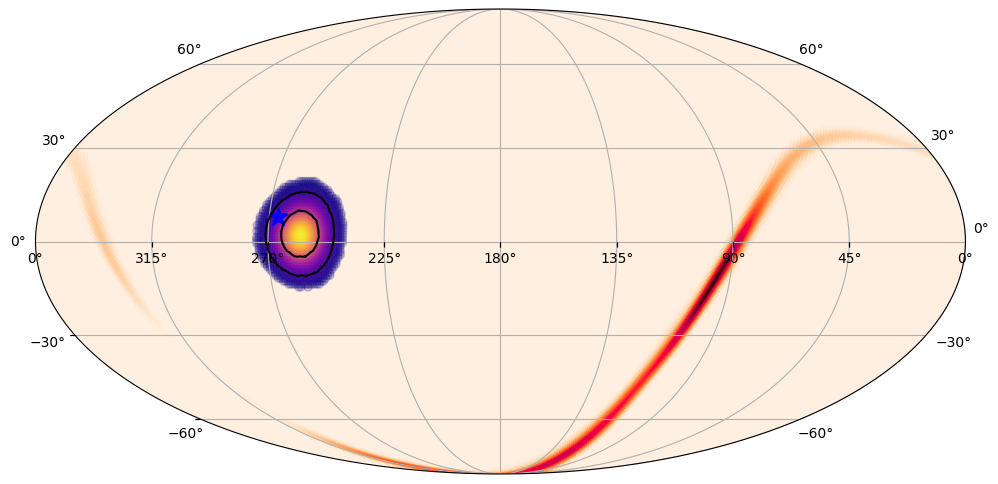

In [24]:
url = 'https://gracedb.ligo.org/api/superevents/S230518h/files/bayestar.fits.gz,1'
skymap = skymap_grb
plot_gw_grb(skymap, url, kn_coords)

In [147]:
# account for parts overlapping with earth?

# fraction of localization on Earth
print('Fraction of localization on Earth:',skymap_grb.geo_probability)

# print percent probability overlaping with gw_skymap and grb_skymap

Fraction of localization on Earth: None


# to get non gaussian shapes:

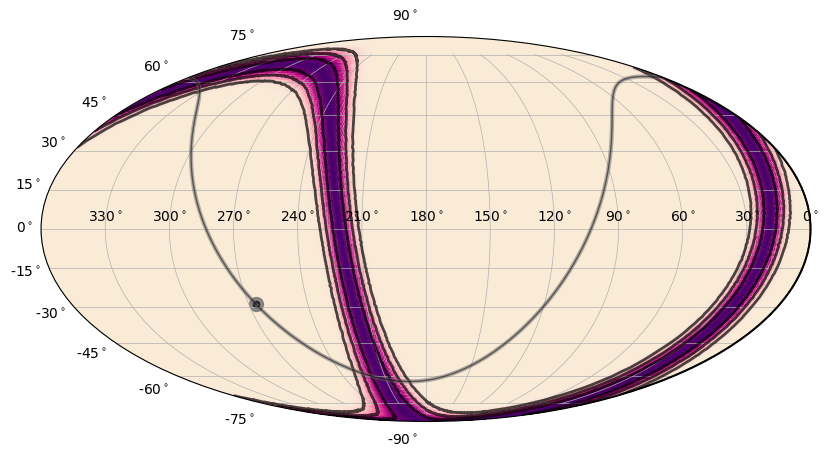

In [7]:
# aternatively: create annulus shaped map given width, radius, and center  

skyplot = EquatorialPlot()

# 3 degree wide annulus with 80 degree radius centered at (ra, dec) = (300, -10)
annulus_map = GbmHealPix.from_annulus(300, -10, 80.0, 3.0)
skyplot.add_localization(annulus_map, detectors=[])

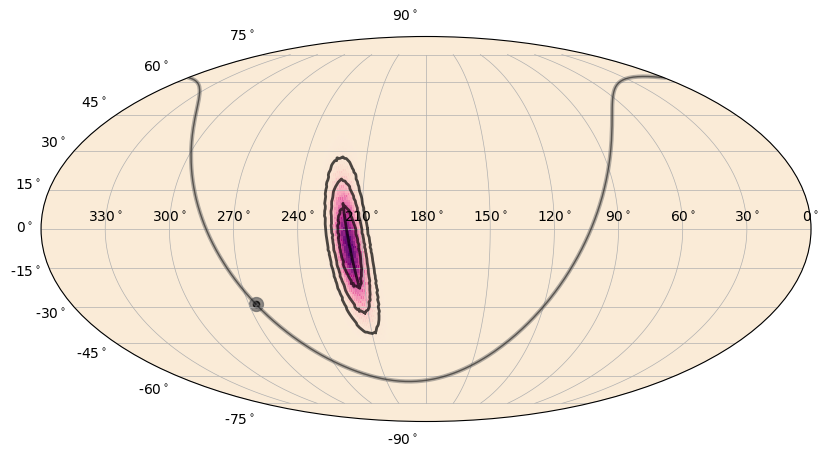

In [8]:
# multiply maps together

skyplot = EquatorialPlot()

# multiply the gaussian map with the annulus map
multiplied = GbmHealPix.multiply(gauss_map, annulus_map)
skyplot.add_localization(multiplied, detectors=[])

In [92]:
def generate_skymap_ellipse():
    gauss_map = GbmHealPix.from_gaussian(180, 0, 10)
    annulus_map = GbmHealPix.from_annulus(300, -10, 80.0, 3.0)
    multiplied = GbmHealPix.multiply(gauss_map, annulus_map)
    return multiplied

def rotate_coords(x, y, centroid):
    angle = np.pi/2
    x_center, y_center = centroid[0], centroid[1]
    #angle = np.random.uniform(0, 2 * np.pi)
    x_translated = x - x_center
    y_translated = y - y_center
    x_rot = np.cos(angle) * x_translated - np.sin(angle) * y_translated   
    y_rot = np.sin(angle) * x_translated + np.cos(angle) * y_translated
    x_rot += x_center
    y_rot += y_center
    return x_rot, y_rot

def transform_coords(gw_skymap, grb_skymap):
    """
    rotation and tranlation
    """
    %matplotlib agg
    ring50, ring90, ra, dec, flattened_probs = extract_skymap_data(grb_skymap)
    
    # rotation
    centroid = grb_skymap.centroid
    ra_rot, dec_rot = rotate_coords(ra, dec, centroid)
    ra50 = [x[0] for x in ring50[0]]
    dec50 = [x[1] for x in ring50[0]]
    ra90 = [x[0] for x in ring90[0]]
    dec90 = [x[1] for x in ring90[0]]
    ra_rot_ring50, dec_rot_ring50 = rotate_coords(ra50, dec50, centroid)
    ra_rot_ring90, dec_rot_ring90 = rotate_coords(ra90, dec90, centroid)

    # translation
    kn_coords_gw = get_kn_coords(gw_skymap)
    select_pixel_grb = random.choices(np.arange(0, len(flattened_probs)), weights=flattened_probs, k=1)[0]
    ra_shift = kn_coords_gw[0] - ra_rot[select_pixel_grb]
    dec_shift = kn_coords_gw[1] - dec_rot[select_pixel_grb]
    ra_rot_trans = ra_rot + ra_shift   
    dec_rot_trans = dec_rot + dec_shift 
    ra_rot_trans_ring50 = ra_rot_ring50 + ra_shift
    dec_rot_trans_ring50 = dec_rot_ring50 + dec_shift
    ra_rot_trans_ring90 = ra_rot_ring90 + ra_shift
    dec_rot_trans_ring90 = dec_rot_ring90 + dec_shift
    ring50_rot_trans =  [[i,j] for i,j in zip(ra_rot_trans_ring50, dec_rot_trans_ring50)]
    ring90_rot_trans =  [[i,j] for i,j in zip(ra_rot_trans_ring90, dec_rot_trans_ring90)]

    return ring50_rot_trans, ring90_rot_trans, ra_rot_trans, dec_rot_trans, flattened_probs, kn_coords_gw

In [106]:
def plot_non_gauss(gw_skymap, grb_skymap, url, kn_coords):
    ring50, ring90, ra, dec, flattened_probs, kn_coords = transform_coords(gw_skymap, grb_skymap)
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': 'astro degrees mollweide'})
    ax.grid()

    # plot GW skymap
    img = ax.imshow_hpx(url, cmap='cylon')
    # img = ax.imshow_hpx('skymaps/gracedb/S230518h.fits', cmap='cylon')

    #plot GRB skymap
    ra50 = [x[0] for x in ring50]
    dec50 = [x[1] for x in ring50]
    ax.plot(ra50, dec50, transform=ax.get_transform('icrs'), c="black")
    ra90 = [x[0] for x in ring90]
    dec90 = [x[1] for x in ring90]
    ax.plot(ra90, dec90, transform=ax.get_transform('icrs'), c="black")

    filtered_indices = np.where(flattened_probs > 0.0001)
    filtered_ra = ra[filtered_indices]
    filtered_dec = dec[filtered_indices]
    filtered_probs = flattened_probs[filtered_indices]
    ax.scatter(filtered_ra, filtered_dec, transform=ax.get_transform('icrs'), c=filtered_probs, cmap='plasma', alpha=0.1)

    # Plot the kn_coords
    ax.scatter(kn_coords[0], kn_coords[1], transform=ax.get_transform('icrs'), color='blue', marker='*', s=200)

    # Show the plot
    plt.show()

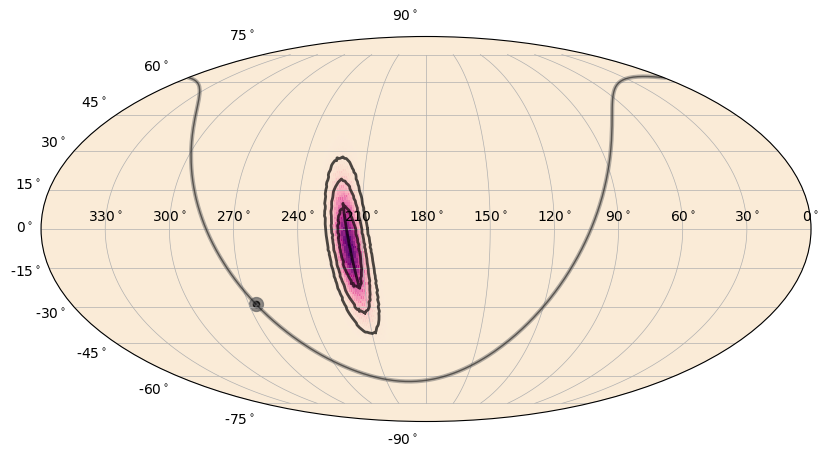

In [107]:
ellipse_map = generate_skymap_ellipse()
equatorial_plot(ellipse_map)

index of KN pixel: 15893, probability: 5.807686825015056e-05


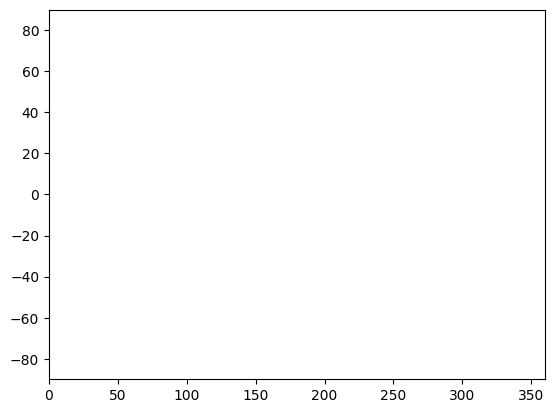

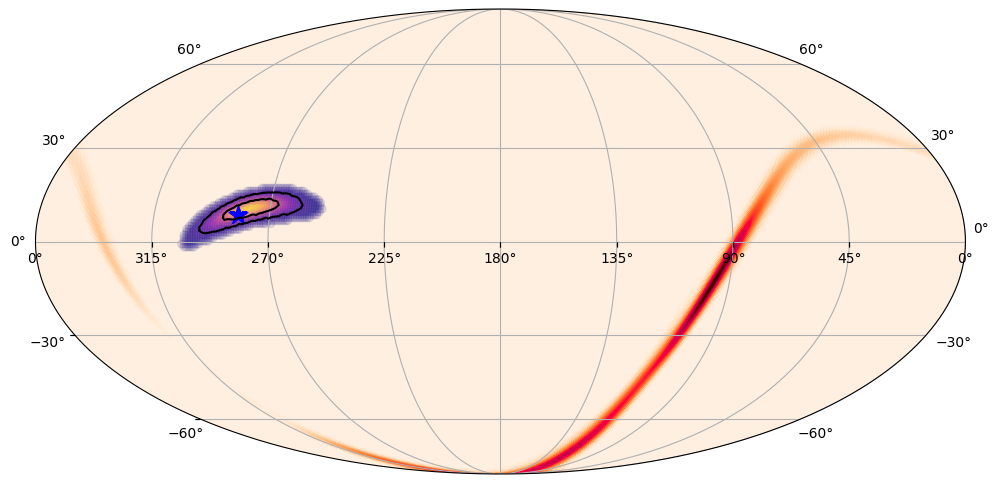

In [108]:
url = 'https://gracedb.ligo.org/api/superevents/S230518h/files/bayestar.fits.gz,1'
skymap = multiplied
plot_non_gauss(example_skymap, multiplied, url, kn_coords)